## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [21]:
# Your code here - remember to use markdown cells for comments as well!

In [2]:
import pandas as pd
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

# Habib Khadri

# Nick Kirbabas

# Seerat Mutneja

# Sidhya Raman

# Douglas Riggs

In [4]:
# Reading table names
pd.read_sql('''
SELECT 
    name
FROM 
    sqlite_schema
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
''',conn)
#Adding a comment to initialize my branch

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## PART 1: Separating out by Genre (Is redone better below)

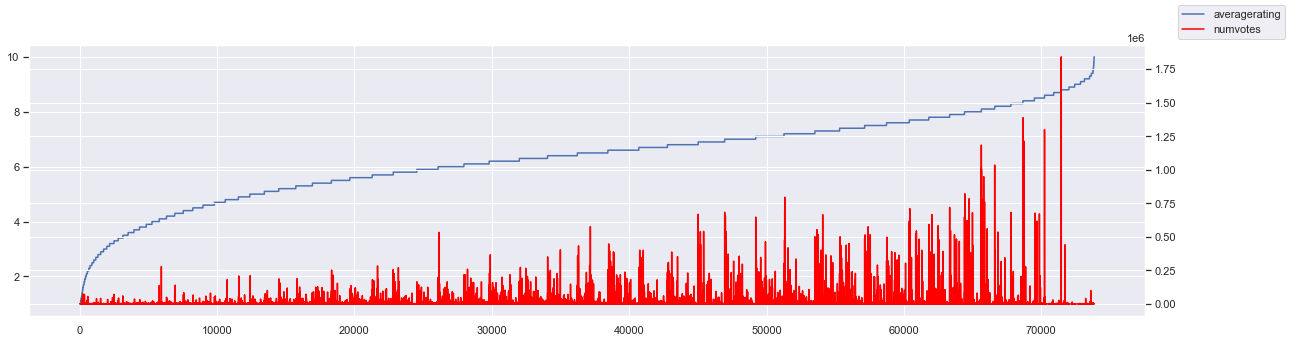

In [3]:
# Get all movies with ratings
movie_df = pd.read_sql('''
SELECT *
FROM movie_basics
INNER JOIN movie_ratings
    USING (movie_id)
ORDER BY averagerating
''',conn)

# Create a plot of averagerating vs numvotes, just for fun
sns.set_theme(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20,5))
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
movie_df.averagerating.plot(ax=ax, stacked=True);
movie_df.numvotes.plot(ax=ax2, stacked=True, color='red');
ax.figure.legend();

<AxesSubplot:xlabel='averagerating', ylabel='Count'>

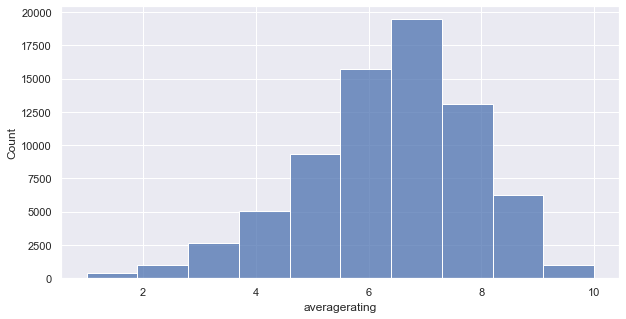

In [6]:
#Creating a distribution of ratings

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(movie_df.averagerating, ax=ax, bins=10)

Looks pretty normal, right?

In [7]:
# check skew/kurtosis, not doing it right now, it's normal, lets be real.

In [46]:
# create dataframe grouped by genre
movie_genre_df = pd.read_sql('''
SELECT genres,
    SUM(averagerating * numvotes) AS rating_raw_points,
    SUM(numvotes) AS genre_num_votes,
    COUNT(movie_id) AS movies_in_genre
FROM movie_basics
INNER JOIN movie_ratings
    USING (movie_id)
GROUP BY genres
ORDER BY genre_num_votes DESC
''',conn)
movie_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genres             923 non-null    object 
 1   rating_raw_points  924 non-null    float64
 2   genre_num_votes    924 non-null    int64  
 3   movies_in_genre    924 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 29.0+ KB


In [47]:
# Splitting the grouped genres into individual rows
separated_movie_genre_df = movie_genre_df.reset_index()
separated_movie_genre_df = pd.DataFrame(movie_genre_df.genres.str.split(','), \
                                        index=separated_movie_genre_df['index'], ).explode('genres')
separated_movie_genre_df.head()




,genres
index,
0,Action
0,Adventure
0,Sci-Fi
1,Action
1,Adventure


In [48]:
# Create a column for how many genres each movie has - after we join,
# We'll use this to separate a movie's votes by each genre.
separated_movie_genre_df['genre_count'] = separated_movie_genre_df.groupby('index').count()
separated_movie_genre_df.head(11)

,genres,genre_count
index,,
0,Action,3
0,Adventure,3
0,Sci-Fi,3
1,Action,3
1,Adventure,3
1,Fantasy,3
2,Adventure,3
2,Animation,3
2,Comedy,3


In [52]:
# Join with original, and divide by genres the movie had.
refined_movie_genre_df = separated_movie_genre_df\
.join(movie_genre_df, how='inner', lsuffix='_separated', rsuffix='_original')
refined_movie_genre_df['rating_raw_points_per_genre'] = \
(refined_movie_genre_df['rating_raw_points'] / refined_movie_genre_df['genre_count']).round()
refined_movie_genre_df['num_votes_per_genre'] = \
(refined_movie_genre_df['genre_num_votes'] / refined_movie_genre_df['genre_count']).round()
# refined_movie_genre_df['movies_in_genre'] = 1

refined_movie_genre_df.head()


,genres_separated,genre_count,genres_original,rating_raw_points,genre_num_votes,movies_in_genre,rating_raw_points_per_genre,num_votes_per_genre
0,Action,3,"Action,Adventure,Sci-Fi",167484518.9,23023248,127,55828173.0,7674416.0
0,Adventure,3,"Action,Adventure,Sci-Fi",167484518.9,23023248,127,55828173.0,7674416.0
0,Sci-Fi,3,"Action,Adventure,Sci-Fi",167484518.9,23023248,127,55828173.0,7674416.0
1,Action,3,"Action,Adventure,Fantasy",64441503.9,9658883,103,21480501.0,3219628.0
1,Adventure,3,"Action,Adventure,Fantasy",64441503.9,9658883,103,21480501.0,3219628.0


In [53]:
# Group by genre, clean out unnecessary columns
refined_movie_genre_df = refined_movie_genre_df\
                            .groupby('genres_separated')\
                            .sum()\
                            .drop('genre_count', axis=1)\
                            .drop('rating_raw_points', axis=1)\
                            .drop('genre_num_votes', axis=1)\
                            .reset_index()
refined_movie_genre_df.head()

,genres_separated,movies_in_genre,rating_raw_points_per_genre,num_votes_per_genre
0,Action,6988,241801383.0,35147088.0
1,Adult,3,175.0,76.0
2,Adventure,3817,200709819.0,28463543.0
3,Animation,1743,37457496.0,5160061.0
4,Biography,3809,57476289.0,7707304.0


In [54]:
grouped_movies_by_genre = refined_movie_genre_df.groupby('genres_separated').sum()
grouped_movies_by_genre.head()

,movies_in_genre,rating_raw_points_per_genre,num_votes_per_genre
genres_separated,,,
Action,6988,241801383.0,35147088.0
Adult,3,175.0,76.0
Adventure,3817,200709819.0,28463543.0
Animation,1743,37457496.0,5160061.0
Biography,3809,57476289.0,7707304.0


128490


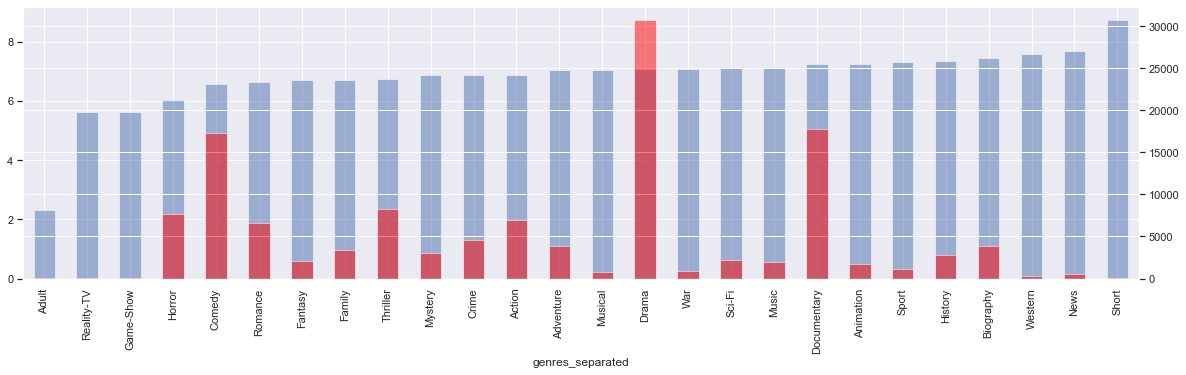

In [55]:
grouped_movies_by_genre['average_rating'] = \
grouped_movies_by_genre['rating_raw_points_per_genre'] \
/ grouped_movies_by_genre['num_votes_per_genre']
print(grouped_movies_by_genre.movies_in_genre.sum())

fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
# movie_df.averagerating.plot(ax=ax, stacked=True);
# movie_df.numvotes.plot(ax=ax2, stacked=True, color='red');

grouped_movies_by_genre.sort_values('average_rating').average_rating\
.plot.bar(ax=ax, alpha = .5);
grouped_movies_by_genre.sort_values('average_rating').movies_in_genre\
.plot.bar(ax=ax2, color='red', alpha=.5);
# ax.figure.legend();


Some sample volumes are really low, might want to throw out genres with < cutoff movies.

### Join IMDB with TN Movie Budgets

In [73]:
imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
INNER JOIN movie_ratings
    USING (movie_id)
''',conn)

imdb_df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43


In [72]:
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets_df.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [71]:
imdb_tn_df = imdb_df.join(tn_movie_budgets_df, how='inner')
imdb_tn_df.head(2)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


### Group based by Genre, Create visuals for that

In [81]:
imdb_tn_split_df = imdb_tn_df.reset_index()
imdb_tn_split_df = pd.DataFrame(imdb_tn_split_df.genres.str.split(','), ).explode('genres')
imdb_tn_split_df.head(2)

,genres
0,Action
0,Crime


In [82]:
imdb_tn_split_df = imdb_tn_split_df\
.join(imdb_tn_df, how='inner', lsuffix='_separated', rsuffix='_original')
# refined_movie_genre_df['rating_raw_points_per_genre'] = \
# (refined_movie_genre_df['rating_raw_points'] / refined_movie_genre_df['genre_count']).round()
# refined_movie_genre_df['num_votes_per_genre'] = \
# (refined_movie_genre_df['genre_num_votes'] / refined_movie_genre_df['genre_count']).round()
# refined_movie_genre_df['movies_in_genre'] = 1

imdb_tn_split_df.head()

,genres_separated,movie_id,primary_title,original_title,start_year,runtime_minutes,genres_original,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Action,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
0,Crime,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
0,Drama,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,Biography,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
1,Drama,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [95]:
# imdb_tn_split_df.info()
imdb_tn_split_df['genre_amount'] = imdb_tn_split_df.genres_original.apply(lambda x: len(str(x).split(',')))
imdb_tn_split_df['rating_points'] = imdb_tn_split_df.averagerating * imdb_tn_split_df.numvotes
imdb_tn_split_df.head()
# imdb_tn_split_df.genre_amount.value_counts()

,genres_separated,movie_id,primary_title,original_title,start_year,runtime_minutes,genres_original,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,genre_amount,rating_points,num_production_budget,num_domestic_gross,num_worldwide_gross
0,Action,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",3,539.0,425000000,760507625,2776345279
0,Crime,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",3,539.0,425000000,760507625,2776345279
0,Drama,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",3,539.0,425000000,760507625,2776345279
1,Biography,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2,309.6,410600000,241063875,1045663875
1,Drama,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2,309.6,410600000,241063875,1045663875


In [140]:
def dollar_string_to_int(cash_string):
    cash_string = cash_string.strip('$')
    cash_string = cash_string.replace(',', '')
    return int(cash_string)

imdb_tn_split_df['num_production_budget'] = imdb_tn_split_df\
                                                .production_budget\
                                                .map(dollar_string_to_int)
imdb_tn_split_df['num_domestic_gross'] = imdb_tn_split_df\
                                                .domestic_gross\
                                                .map(dollar_string_to_int)
imdb_tn_split_df['num_worldwide_gross'] = imdb_tn_split_df\
                                                .worldwide_gross\
                                                .map(dollar_string_to_int)

In [141]:
genre_df = imdb_tn_split_df.groupby('genres_separated').agg({
    'runtime_minutes':'mean',
    'rating_points':'sum',
    'numvotes':'sum',
    'num_production_budget': 'sum',
    'num_domestic_gross':'sum',
    'num_worldwide_gross':'sum',
    'genre_amount':'mean',
    'movie_id':'count'
    
    
})

In [142]:
genre_df

,runtime_minutes,rating_points,numvotes,num_production_budget,num_domestic_gross,num_worldwide_gross,genre_amount,movie_id
genres_separated,,,,,,,,
Action,104.197203,3.360550e+08,48735045,28685265329,35952699909,82093396128,2.711286,762
Adventure,102.635535,3.013307e+08,42577322,20262533000,24846313142,57627316868,2.818985,453
Animation,90.671329,4.637397e+07,6365499,7752080000,9026991477,20852376217,2.626667,150
Biography,99.415842,6.597901e+07,8771353,9325741619,12615447543,27506862325,2.717532,308
Comedy,96.572608,1.846677e+08,27648209,50608519993,65074479168,147021884922,2.134640,1582
Crime,101.060547,1.054610e+08,15226708,18640628082,25160217368,58245867035,2.744485,544
Documentary,83.261608,4.720259e+06,622275,23204130607,33711362895,67715513829,1.655391,946
Drama,100.124108,3.097234e+08,43618937,83661240362,109737352710,243922877184,2.074197,2709
Family,93.675799,3.298303e+07,4869485,7428555907,9628702832,19681393051,2.550218,229


In [144]:
genre_df.columns = ['runtime_minutes', 'rating_points', 'numvotes', 'num_production_budget',
       'num_domestic_gross', 'num_worldwide_gross', 'genre_amount',
       'movie_count'];
genre_df = genre_df[(genre_df.numvotes >= 10000) & (genre_df.movie_count >= 100)]

In [155]:
genre_df['gross_profit_per_movie'] = (genre_df.num_worldwide_gross - genre_df.num_production_budget) / genre_df.movie_count
genre_df['profit_ratio'] = genre_df.num_worldwide_gross / genre_df.num_production_budget
genre_df['average_rating'] = genre_df['rating_points'] / genre_df['numvotes']
genre_df['numvotes_per_movie'] = genre_df.numvotes / genre_df.movie_count

<ipython-input-155-f5049cd82c7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['gross_profit_per_movie'] = (genre_df.num_worldwide_gross - genre_df.num_production_budget) / genre_df.movie_count
<ipython-input-155-f5049cd82c7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['profit_ratio'] = genre_df.num_worldwide_gross / genre_df.num_production_budget
<ipython-input-155-f5049cd82c7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

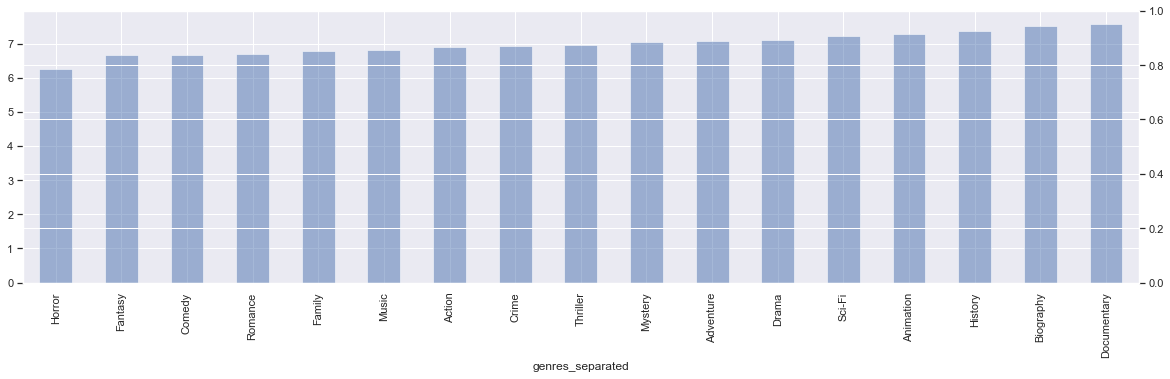

In [151]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
genre_df.sort_values('average_rating').average_rating\
.plot.bar(ax=ax, alpha = .5);

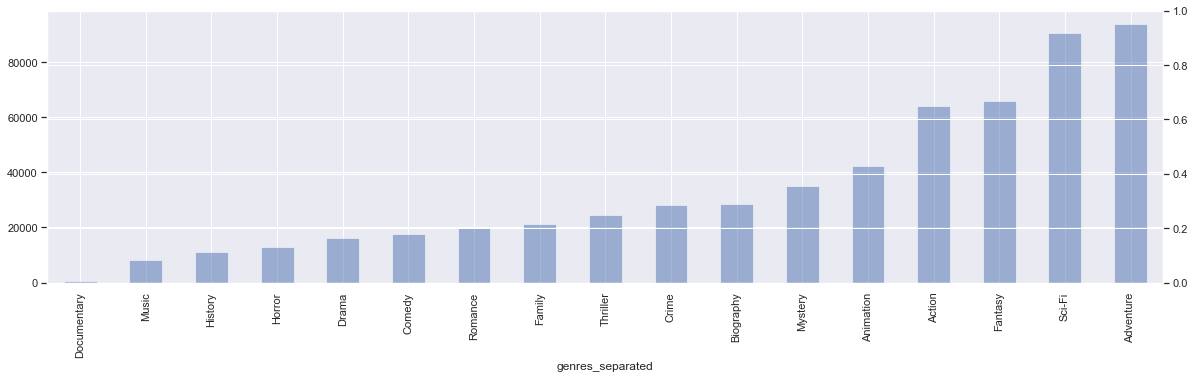

In [157]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
genre_df.sort_values('numvotes_per_movie').numvotes_per_movie\
.plot.bar(ax=ax, alpha = .5);

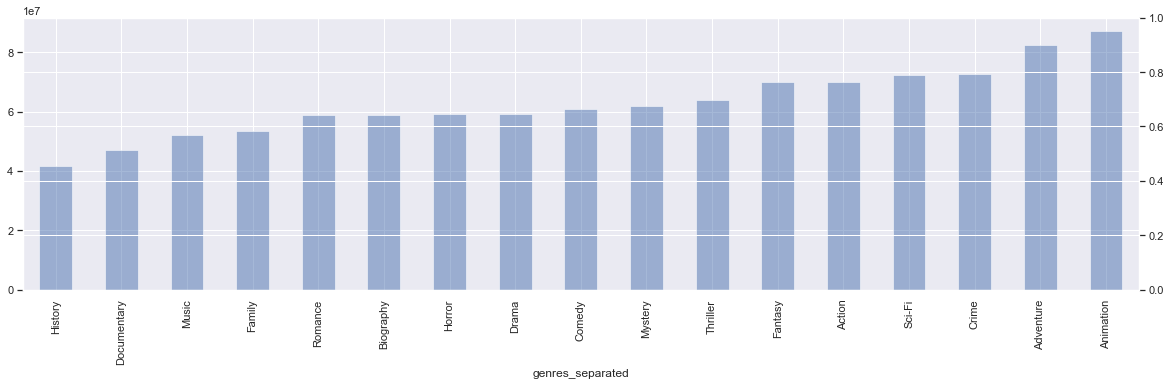

In [158]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
genre_df.sort_values('gross_profit_per_movie').gross_profit_per_movie\
.plot.bar(ax=ax, alpha = .5);

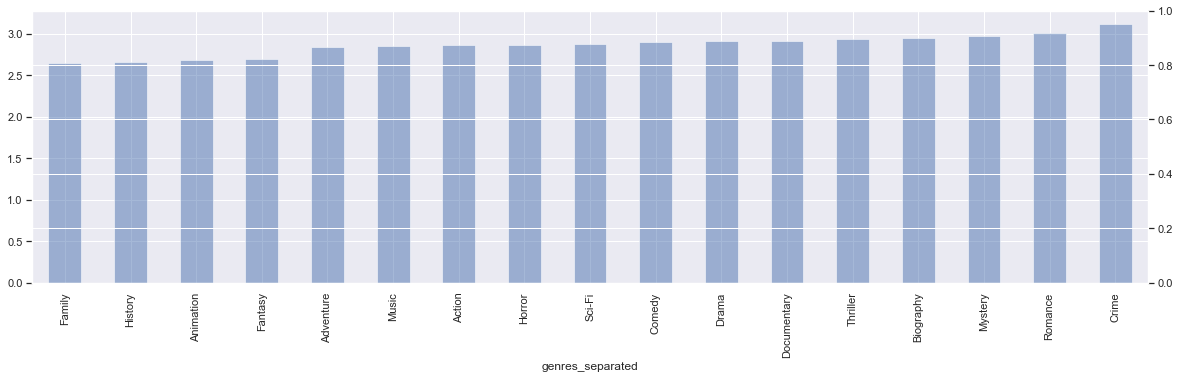

In [160]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
genre_df.sort_values('profit_ratio').profit_ratio\
.plot.bar(ax=ax, alpha = .5);

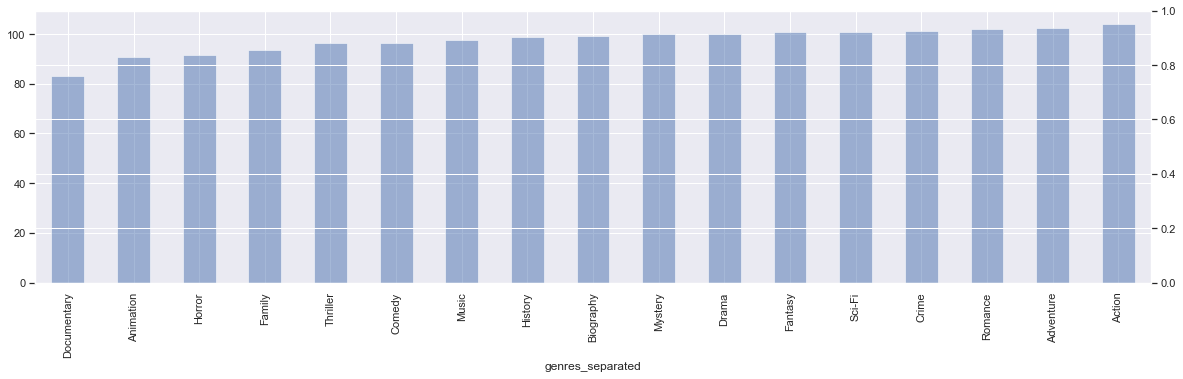

In [154]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
genre_df.sort_values('runtime_minutes').runtime_minutes\
.plot.bar(ax=ax, alpha = .5);

## PART 2: File Exploration

In [14]:
bom_movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
bom_movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [15]:
bom_movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [161]:
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_movie_info_df.head(10)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN
9,15,When a diamond expedition in the Congo is lost...,PG-13,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,NaN,108 minutes,NaN


In [17]:
rt_movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [19]:
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t',\
                            encoding = 'unicode_escape')
rt_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [20]:
rt_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [21]:
tmdb_movies_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tmdb_movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [26]:
tmdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [22]:
tn_movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
tn_movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [27]:
tn_movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     5782 non-null   int64 
 1   release_date           5782 non-null   object
 2   movie                  5782 non-null   object
 3   production_budget      5782 non-null   object
 4   domestic_gross         5782 non-null   object
 5   worldwide_gross        5782 non-null   object
 6   num_production_budget  5782 non-null   int64 
 7   num_domestic_gross     5782 non-null   int64 
 8   num_worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 406.7+ KB


In [30]:
imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
INNER JOIN movie_ratings
    USING (movie_id)
''',conn)
imdb_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [31]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


## PART 3: Cleaning/Small graphs for budget/gross

In [59]:
def dollar_string_to_int(cash_string):
    cash_string = cash_string.strip('$')
    cash_string = cash_string.replace(',', '')
    return int(cash_string)

clean_budgets_df = tn_movie_budgets_df
clean_budgets_df['num_production_budget'] = clean_budgets_df\
                                                .production_budget\
                                                .map(dollar_string_to_int)
clean_budgets_df['num_domestic_gross'] = clean_budgets_df\
                                                .domestic_gross\
                                                .map(dollar_string_to_int)
clean_budgets_df['num_worldwide_gross'] = clean_budgets_df\
                                                .worldwide_gross\
                                                .map(dollar_string_to_int)

clean_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,num_production_budget,num_domestic_gross,num_worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317000000,620181382,1316721747


In [24]:

# fig, ax = plt.subplots(figsize=(20,5))
# ax2 = ax.twinx()
sns.scatterplot(x=tn_movie_budgets_df['production_budget'], y=tn_movie_budgets_df['domestic_gross']);
# sns.scatterplot(ax=ax, data=tn_movie_budgets_df, x='production_budget', y='domestic_gross');
# movie_df.averagerating.plot(ax=ax, stacked=True);
# movie_df.numvotes.plot(ax=ax2, stacked=True, color='red');

# grouped_movies_by_genre.sort_values('average_rating').average_rating\
# .plot.bar(ax=ax, alpha = .5);
# grouped_movies_by_genre.sort_values('average_rating').movies_in_genre\
# .plot.bar(ax=ax2, color='red', alpha=.5);
# ax.figure.legend();

Error in callback <function flush_figures at 0x7fafb0e071f0> (for post_execute):


KeyboardInterrupt: 

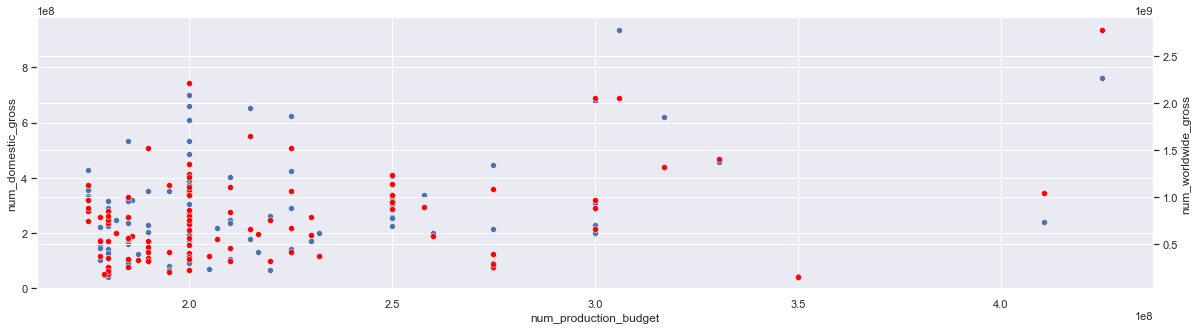

In [25]:
fig, ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
scatterplot = \
    sns.scatterplot(x=clean_budgets_df.head(100)['num_production_budget'],\
                    y=clean_budgets_df.head(100)['num_domestic_gross'],\
                   ax=ax);
scatterplot = \
    sns.scatterplot(x=clean_budgets_df.head(100)['num_production_budget'],\
                    y=clean_budgets_df.head(100)['num_worldwide_gross'],\
                   ax=ax2,\
                   color='red');
# ax.legend()
# ax2.legend()
# plt.plot([0, 0], [400000000, 400000000], linewidth=10)
# plt.plot([0, 0], [400000000, 400000000], linewidth=10)
# g = sns.scatterplot(data = df, y  = s_y, x = s_x)
# ax.set_xticks([0,10,20,30,40,50,60,70,80,90])
# ax.set_yticks([0,10,20,30,40,50,60,70,80,90])
# ax.set_xticklabels(['0','a','b','c','d','e'])




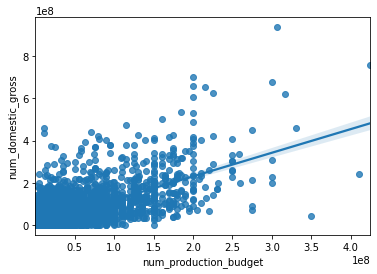

In [60]:
sns.regplot(x="num_production_budget",
            y="num_domestic_gross", 
            data=clean_budgets_df);

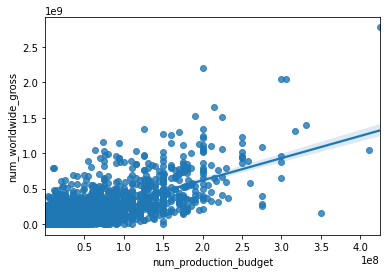

In [61]:
sns.regplot(x="num_production_budget",
            y="num_worldwide_gross", 
            data=clean_budgets_df);

In [66]:
clean_budgets_df.corr()

,id,num_production_budget,num_domestic_gross,num_worldwide_gross
id,1.000000,-0.035278,0.008255,-0.009422
num_production_budget,-0.035278,1.000000,0.685682,0.748306
num_domestic_gross,0.008255,0.685682,1.000000,0.938853
num_worldwide_gross,-0.009422,0.748306,0.938853,1.000000


### Metric/success indicator ideas

## Experimentation

In [162]:
tmdb_movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [169]:
tn_movie_budgets_df.head()
def dollar_string_to_int(cash_string):
    cash_string = cash_string.strip('$')
    cash_string = cash_string.replace(',', '')
    return int(cash_string)

clean_budgets_df = tn_movie_budgets_df
clean_budgets_df['num_production_budget'] = clean_budgets_df\
                                                .production_budget\
                                                .map(dollar_string_to_int)
clean_budgets_df['num_domestic_gross'] = clean_budgets_df\
                                                .domestic_gross\
                                                .map(dollar_string_to_int)
clean_budgets_df['num_worldwide_gross'] = clean_budgets_df\
                                                .worldwide_gross\
                                                .map(dollar_string_to_int)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [180]:
# tmdb_movies_df.set_index('original_title')
# tn_movie_budgets_df.set_index('movie')
# tmdb_movies_df.reset_index()
# tn_movie_budgets_df.reset_index()
tmdb_tn_df = tmdb_movies_df.join(clean_budgets_df,  how='inner', lsuffix='_tmdb', rsuffix='_original')
tmdb_tn_df.head()

,Unnamed: 0,genre_ids,id_tmdb,original_language,original_title,popularity,release_date_tmdb,title,vote_average,vote_count,id_original,release_date_original,movie,production_budget,domestic_gross,worldwide_gross,num_production_budget,num_domestic_gross,num_worldwide_gross
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",425000000,760507625,2776345279
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410600000,241063875,1045663875
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350000000,42762350,149762350
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330600000,459005868,1403013963
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317000000,620181382,1316721747


In [184]:
language_df = tmdb_tn_df.groupby('original_language').agg({
    'id_tmdb':'count',
    'popularity':'mean',
    'vote_average':'mean',
    'vote_count':'mean',
    'num_production_budget':'mean',
    'num_worldwide_gross':'mean'
})
language_df.head()
# language_df.reset_index()
language_df[language_df.id_tmdb >= 10]

,id_tmdb,popularity,vote_average,vote_count,num_production_budget,num_worldwide_gross
original_language,,,,,,
cn,18,5.424611,6.377778,222.722222,3.044167e+07,4.705338e+07
da,19,4.428316,6.694737,158.894737,3.368947e+07,9.445588e+07
de,83,3.196795,5.878313,41.722892,3.076390e+07,8.914538e+07
en,4898,3.386875,5.792303,271.924051,3.118917e+07,9.144634e+07
es,102,3.046490,6.237255,98.245098,3.727889e+07,1.055692e+08
fr,165,4.499994,6.054545,181.478788,3.547563e+07,1.063836e+08
he,10,2.094700,6.420000,11.700000,2.142500e+07,1.056373e+08
hi,53,3.450075,5.775472,40.641509,4.278325e+07,1.225590e+08
it,49,2.518816,6.112245,62.795918,3.880565e+07,1.154632e+08


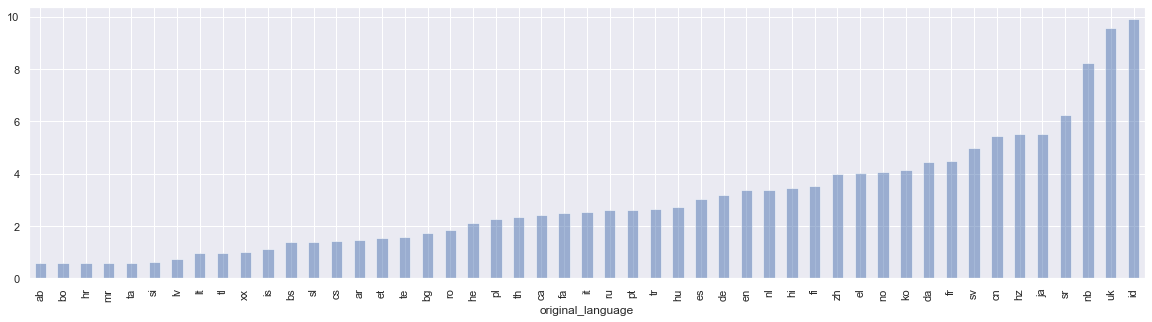

In [190]:
fig, ax = plt.subplots(figsize=(20,5))
language_df.sort_values('popularity').popularity\
.plot.bar(ax=ax, alpha = .5);

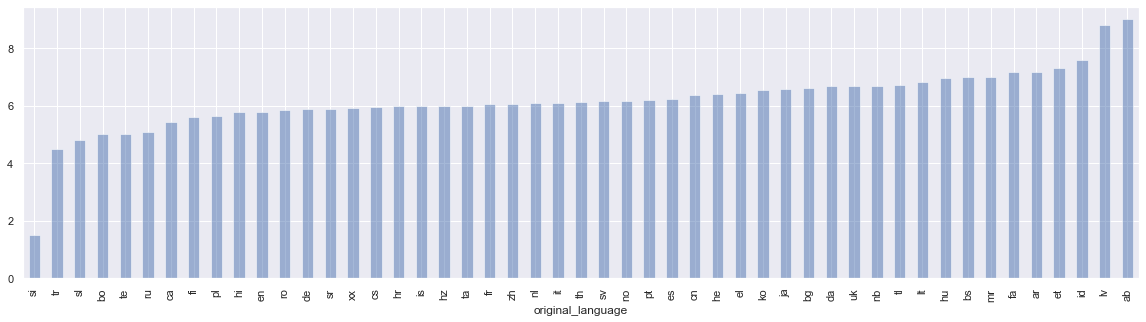

In [189]:
fig, ax = plt.subplots(figsize=(20,5))
language_df.sort_values('vote_average').vote_average\
.plot.bar(ax=ax, alpha = .5);

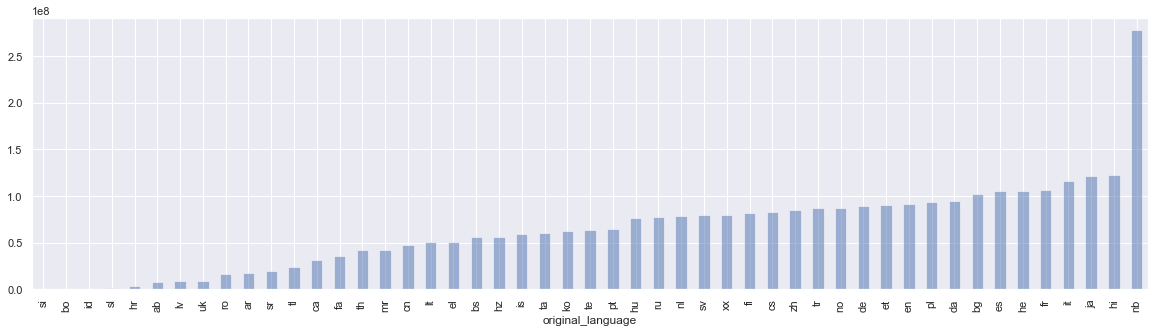

In [188]:
fig, ax = plt.subplots(figsize=(20,5))
language_df.sort_values('num_worldwide_gross').num_worldwide_gross\
.plot.bar(ax=ax, alpha = .5);

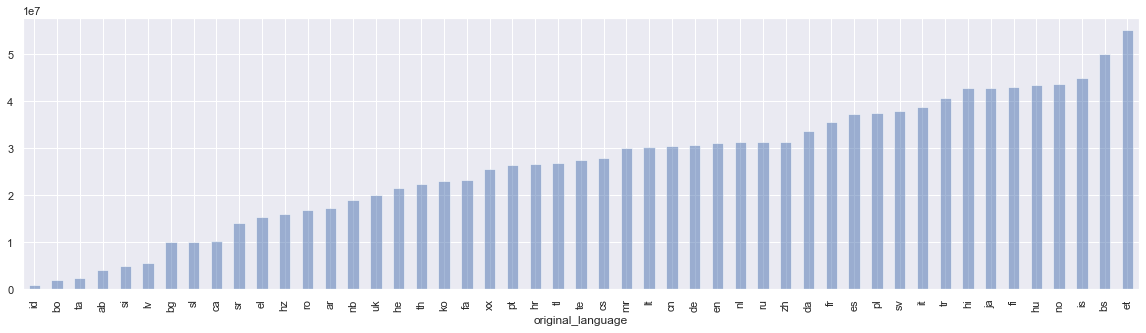

In [192]:
fig, ax = plt.subplots(figsize=(20,5))
language_df.sort_values('num_production_budget').num_production_budget\
.plot.bar(ax=ax, alpha = .5);

Possible Metrics: 

- Gross Raw Value (Could be split into domestic and global)

- Profit %

- Rating

- Vote count

- Popularity (tmdb)

Potential Indicators of Success:

- Actor

- Director

- Genre

- Budget

- Runtime

- Rating (G, PG, PG-13, R, etc)


# Andrew Yang